In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
inspector = inspect(engine)
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# find the last date in the dataset
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# convert to datetime type
mydate = dt.datetime.strptime(last_date[0], "%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database
start_date = dt.date((int(mydate.strftime('%Y')) - 1), int(mydate.strftime('%m')), int(mydate.strftime('%d')))

# Save the query results as a Pandas DataFrame and set the index to the date column
# Perform a query to retrieve the data and precipitation scores
df = pd.read_sql_query(session.query(Measurement.prcp.label("precipitation"), Measurement.date).filter(Measurement.date >= start_date).statement, engine, index_col=['date'])
                                  
df.head()



,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


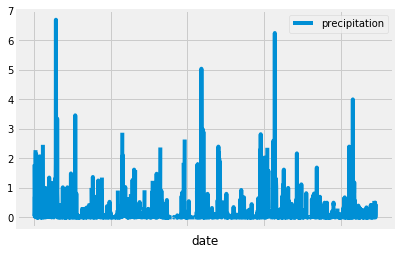

In [12]:
# Sort the dataframe by date
df.sort_index(inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data

df.plot()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct(Measurement.station).count()

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationCounts = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()
stationCounts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
busiestStation = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(desc(func.count(Measurement.tobs))).first()
busiestStation

('USC00519281', 2772)

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

session.query(func.min(Measurement.tobs).label("min temp"), func.max(Measurement.tobs).label("max temp"), func.avg(Measurement.tobs).label("avg temp")).all()

[(53.0, 87.0, 73.09795396419437)]

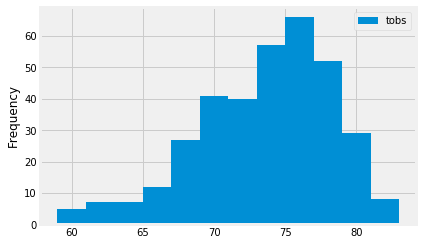

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df2 = pd.read_sql_query(session.query(Measurement.tobs).filter(Measurement.date > start_date).filter(Measurement.station==busiestStation[0]).statement, engine)
df2.plot(kind='hist', bins=12)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Travel dates: 2019-05-23 to 2019-05-28

tmp_avgs = calc_temps('2017-05-23', '2017-05-28')
tmp_avgs

[(69.0, 75.2, 87.0)]

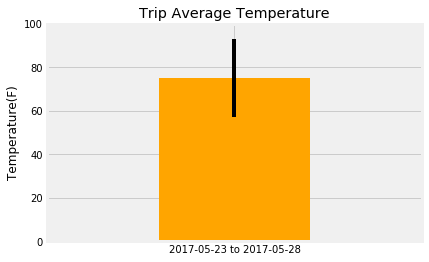

In [80]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df = pd.DataFrame(tmp_avgs, columns=['Min', "Avg", "max"])
# df.plot( , 'Avg', kind='bar')
# df
yerr = tmp_avgs[0][2] - tmp_avgs[0][0]
plt.bar('2017-05-23 to 2017-05-28', tmp_avgs[0][1], color='orange', yerr=yerr)
plt.ylabel("Temperature(F)")
plt.title('Trip Average Temperature')
plt.ylim(0,100)
plt.xlim(-1,1)
plt.show()

In [108]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def calc_rainfall(start_date, end_date):
    """rainfall total for a list of dates.

    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d

    Returns:
        total rainfall
    """
    return session.query(Measurement.station, Measurement.prcp).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).all()

calc_rainfall('2017-05-23', '2017-05-28')


[('USC00513117', 0.02),
 ('USC00514830', 0.11),
 ('USC00516128', 0.44),
 ('USC00519281', 0.06),
 ('USC00519397', 0.08),
 ('USC00519523', 0.0)]

## Optional Challenge Assignment

In [115]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [259]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`


# Set the start and end date of the trip

dt_start = dt.datetime.strptime('2018-01-01', '%Y-%m-%d')
dt_end = dt.datetime.strptime('2018-01-07', '%Y-%m-%d')

# Use the start and end date to create a range of dates

numdays = (dt_end - dt_start).days
date_range = []

for x in range(numdays+1):
    mydate = dt_start + dt.timedelta(days=x)
    date_range.append(mydate)

# Stip off the year and save a list of %m-%d strings
date_list = [mydate.strftime("%m-%d") for mydate in date_range]
# print(date_list)

#Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for mydate in date_list:
    normals.extend(daily_normals(mydate))       
# normals


2018-01-01
2018-01-02
2018-01-03
2018-01-04
2018-01-05
2018-01-06
2018-01-07


In [246]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['Min', 'Avg', 'Max'])
df['Date'] = date_list
df.set_index('Date',inplace=True)
df

,Min,Avg,Max
Date,,,
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0


[Text(0, 0, '2018-01-01'),
 Text(0, 0, '2018-01-02'),
 Text(0, 0, '2018-01-03'),
 Text(0, 0, '2018-01-04'),
 Text(0, 0, '2018-01-05'),
 Text(0, 0, '2018-01-06'),
 Text(0, 0, '2018-01-07')]

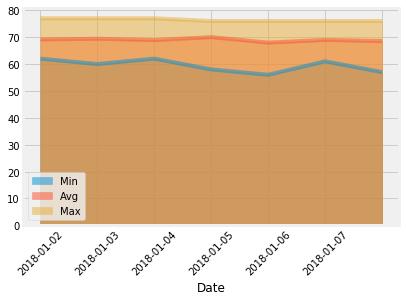

In [272]:
# Plot the daily normals as an area plot with `stacked=False`

x_ticks = [mydate.strftime("%Y-%m-%d") for mydate in date_range]    
ax = df.plot(kind='area', stacked=False)
# ax.set_xlim(0, 8)
ax.set_xticklabels(x_ticks, rotation=45)

